## PHOTOMETRIC CALIBRATION IN PHOEBE

### Background.

When measuring incident light from a source, there are several radiative properties that we need to distinguish:

* Luminosity: describe luminosity
* Flux: describe flux
* Intensity: describe intensity

The measured physical quantity from an unresolved source is thus flux, measured in $\mathrm{W}/\mathrm{m}^2$. However, in astronomy it is customary to use magnitudes instead; to transform fluxes to magnitudes or vice versa, we need to know a reference value for flux, $f_0$, that corresponds to a reference value for magnitude, $m_0$. Once we have that, the transformation is given by:

$$ m = m_0 - \frac 52 \log_{10} \frac{f}{f_0} \quad \textrm{ and conversely } \quad f = f_0 10^{-2/5 (m - m_0)}. $$

For example, we could set $m_0 = 0$ to correspond to $f_0 = 1\,\mathrm{W}/\mathrm{m}^2$.

In the context of PHOEBE, by ``passband'' we denote the combined photometric response of the filter, telescope optics, detector quantum efficiency, and any other systematic effects that affect the throughput. Given an input of uniform intensity across all wavelengths, a passband transmission function determines flux density ($df/d\lambda$) at each wavelength $\lambda$. Let us take a look at Johnson B and V filters.

In [1]:
import phoebe

jB = phoebe.get_passband('Johnson:B')
jV = phoebe.get_passband('Johnson:V')

In [2]:
import matplotlib.pyplot as plt
plt.style.use('jupyter')

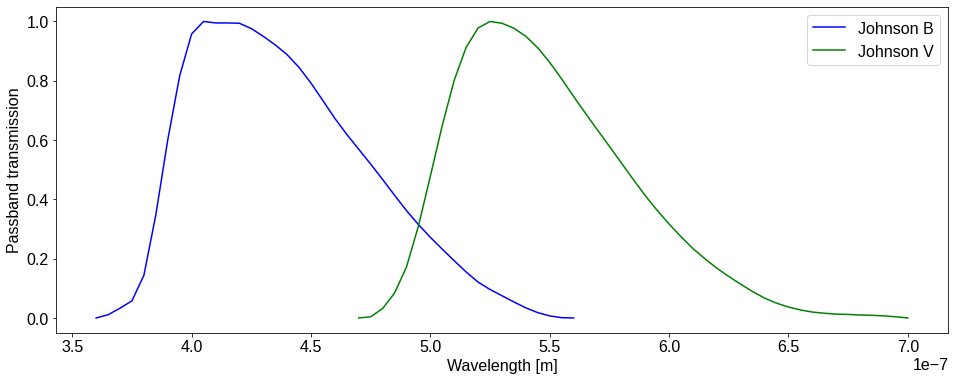

In [3]:
plt.xlabel('Wavelength [m]')
plt.ylabel('Passband transmission')
plt.plot(jB.ptf_table['wl'], jB.ptf_table['fl'], 'b-', label='Johnson B')
plt.plot(jV.ptf_table['wl'], jV.ptf_table['fl'], 'g-', label='Johnson V')
plt.legend()

Now let's read in a theoretical spectral energy distribution (SED) of a Sun-like star (T=5750K, logg=4.5, abun=0.0) as calculated by Kurucz's model atmospheres:

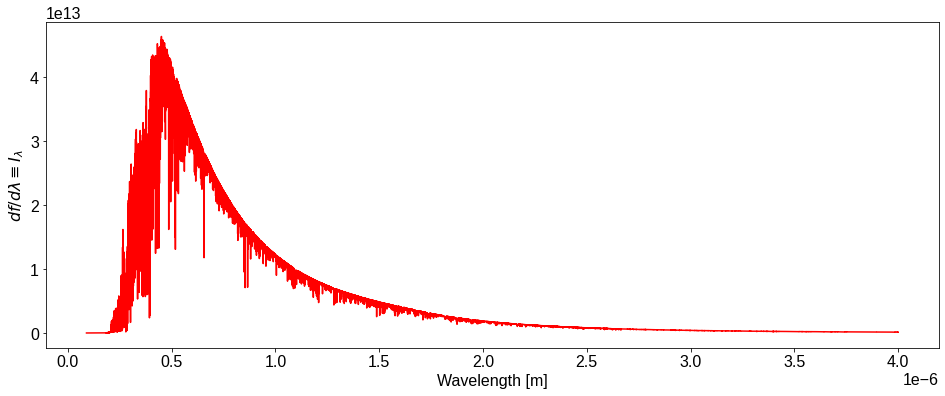

In [5]:
import numpy as np
from astropy.io import fits

with fits.open('T05750G45P00.fits') as hdul:
    ints = hdul[0].data[-1,:]*1e7  # erg/s/cm^2/A -> W/m^3
wls = np.arange(900., 39999.501, 0.5)/1e10 # AA -> m

plt.xlabel('Wavelength [m]')
plt.ylabel('$df/d\lambda \equiv I_\lambda$')
plt.plot(wls, ints, 'r-')


Now we can zoom in on the parts covered by the Johnson B and V passbands:

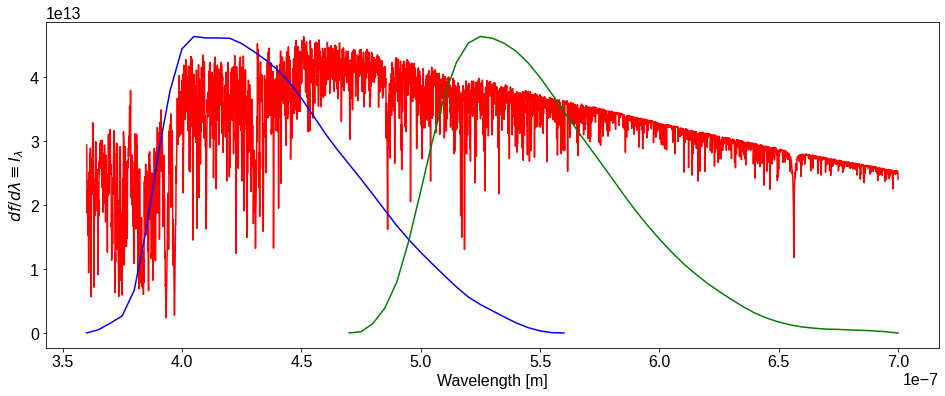

In [10]:
flt = (wls > jB.ptf_table['wl'][0]) & (wls < jV.ptf_table['wl'][-1])
wls = wls[flt]
ints = ints[flt]

plt.xlabel('Wavelength [m]')
plt.ylabel('$df/d\lambda \equiv I_\lambda$')
plt.plot(wls, ints, 'r-')
plt.plot(jB.ptf_table['wl'], max(ints)*jB.ptf_table['fl'], 'b-')
plt.plot(jV.ptf_table['wl'], max(ints)*jV.ptf_table['fl'], 'g-')

The SED received by the detector in each passband is the product of the passband response function and the SED:

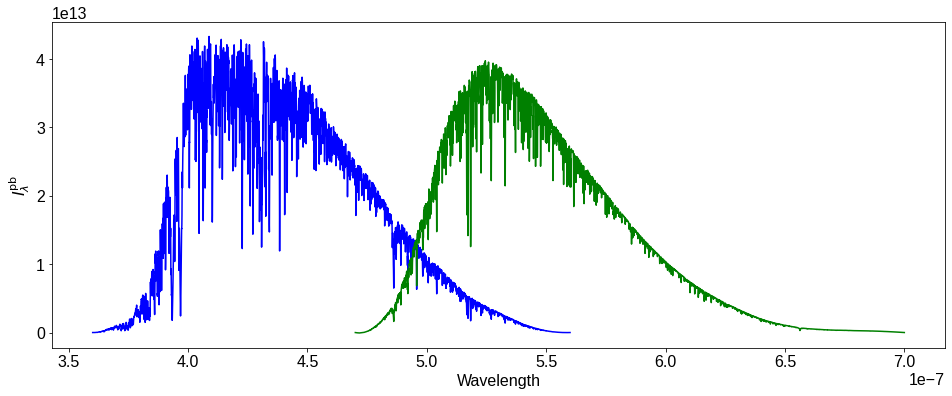

In [15]:
flt_B = (wls >= jB.ptf_table['wl'][0]) & (wls <= jB.ptf_table['wl'][-1])
wls_B = wls[flt_B]
ints_B = ints[flt_B]*jB.ptf(wls_B)

flt_V = (wls >= jV.ptf_table['wl'][0]) & (wls <= jV.ptf_table['wl'][-1])
wls_V = wls[flt_V]
ints_V = ints[flt_V]*jV.ptf(wls_V)

plt.xlabel('Wavelength')
plt.ylabel('$I_\lambda^\mathrm{pb}$')
plt.plot(wls_B, ints_B, 'b-')
plt.plot(wls_V, ints_V, 'g-')

Note that the y-axis here is passband intensity, measured in $\mathrm{W}/\mathrm{m}^3$. If we want to get the amount of flux received in each passband, it is the integral of passband intensity over wavelength, $F = \int_\lambda I_\lambda d\lambda$:

In [16]:
dwl = wls[1]-wls[0]
fl_B = np.sum(ints_B)*dwl
fl_V = np.sum(ints_V)*dwl
print(f'flux in B-band: {fl_B}\nflux in V-band: {fl_V}')

flux in B-band: 3209706.1982748867
flux in V-band: 2990519.8042755253


This allows us to calculate the mean passband intensity, $\langle I \rangle = \frac{\int_\lambda P(\lambda) S(\lambda) d\lambda}{\int_\lambda P(\lambda) d\lambda}$, which is in the units of $\mathrm{W}/\mathrm{m}^3$:

In [18]:
pbi_B = fl_B/jB.ptf_area
pbi_V = fl_V/jV.ptf_area
print(f'B-band mean intensity: {pbi_B}\nV-band mean intensity: {pbi_V}')

B-band mean intensity: 35165844409241.39
V-band mean intensity: 34881685716054.684


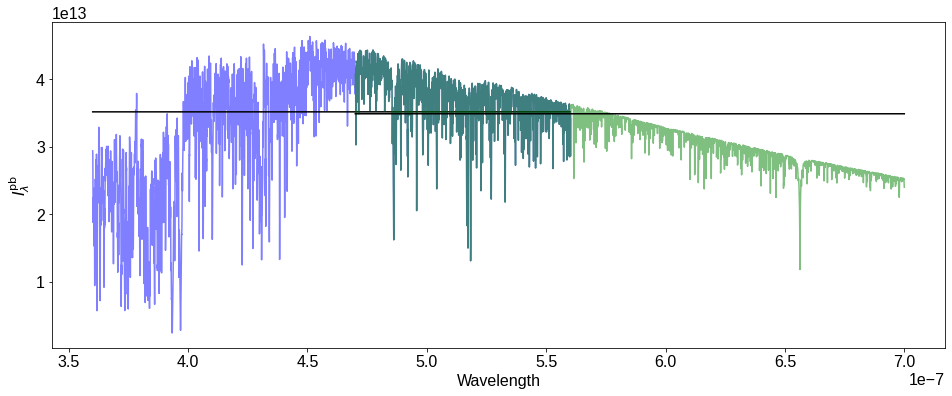

In [39]:
plt.xlabel('Wavelength')
plt.ylabel('$I_\lambda^\mathrm{pb}$')
plt.plot(wls_B, ints[flt_B], 'b-', alpha=0.5)
plt.plot(wls_B, np.ones_like(ints_B)*pbi_B, 'k-')
plt.plot(wls_V, ints[flt_V], 'g-', alpha=0.5)
plt.plot(wls_V, np.ones_like(ints_V)*pbi_V, 'k-')

In [42]:
print(pbi_B/np.mean(ints[flt_B]))
print(pbi_V/np.mean(ints[flt_V]))

1.032316843470434
1.070545704615506


In [33]:
jB.Inorm(atm='ck2004', Teff=5750, logg=4.5, abun=0.0)

array([3.51658444e+13])

In [34]:
pbu_B = np.ones_like(ints_B)*pbi_B

In [37]:
(pbu_B*jB.ptf(wls_B)).sum()

6.4194124077998104e+16

In [36]:
ints_B.sum()

6.419412396549291e+16